In [ ]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import random

#Metro

In [ ]:
def Metro(L, iterations):

    def neighbor(value):
        left = (value - 1) % L + (value // L) * L
        right = (value + 1) % L + (value // L) * L
        up = (value - L) % (L * L)
        down = (value + L) % (L * L)
        return [left, right, up, down]

    def energy(S):
        E = 0
        for i in range(L**2):
            temp = neighbor(i)
            n = S[np.where(num == i)]
            l = S[np.where(num == temp[0])]
            r = S[np.where(num == temp[1])]
            u = S[np.where(num == temp[2])]
            d = S[np.where(num == temp[3])]
            value = n * (l + r + u + d)
            E += value
        return float(-E / 2)

    def new_energy(new, i, j):
        temp = neighbor(num[i, j])
        n = new[i, j]
        l = new[np.where(num == temp[0])]
        r = new[np.where(num == temp[1])]
        u = new[np.where(num == temp[2])]
        d = new[np.where(num == temp[3])]
        change = 2 * n * (l + r + u + d)
        return float(change)

    def alp(old, new, B):
        ex4 = np.exp(-B * 4)
        ex8 = np.exp(-B * 8)
        ex_dict = {4: ex4, 8: ex8}
        if old < new:
            result = ex_dict[new - old]
        else:
            result = 1
        return result

    num = np.arange(L**2).reshape((L, L))
    Emean = []
    Smean = []
    err = []

    for b in np.arange(0.1, 1.0, 0.1):
        temp_E = []
        temp_S = []
        for _ in range(10) :
            B = float(b)
            S = np.random.choice([-1, 1], size=(L, L))
            E_list = []
            m_list = []
            old = energy(S)

            for _ in range(iterations):
                random_index = np.random.randint(0, L, size=2)
                i, j = random_index
                new_S = np.copy(S)
                new_S[i, j] *= -1
                new = old - new_energy(new_S, i, j)
                p = alp(old, new, B)
                value = np.random.choice([old, new], p=[1 - p, p])
                if value == new:
                    S = new_S
                    old = new

                E_list.append(old)
                m_list.append(np.sum(S) / L**2)
            temp_E.append(np.mean(E_list[100:]))
            temp_S.append(abs(np.mean(m_list[100:])))

        Emean.append(np.mean(temp_E))
        Smean.append(np.mean(temp_S))

    return Emean, Smean

<ipython-input-19-6f39fb1ec422>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(-E / 2)
<ipython-input-19-6f39fb1ec422>:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(change)


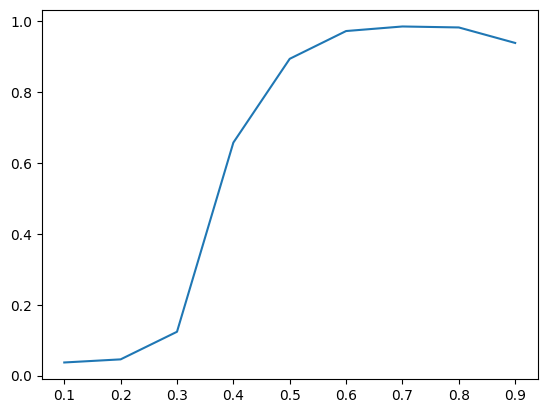

In [ ]:
Ms = Metro(5, 1000)[1]
plt.plot(np.arange(0.1, 1.0, 0.1),Ms)

#Wolff

In [ ]:
def initialize_spins(L):
    return np.random.choice([-1, 1], size=(L, L))

def neighbors(L, x, y):
    neighbors = [(x, (y+1)%L), (x, (y-1)%L), ((x+1)%L, y), ((x-1)%L, y)]
    return neighbors

def wolff(spins, B):
    L = spins.shape[0]
    x, y = random.randint(0, L-1), random.randint(0, L-1)
    seed_spin = spins[x, y]

    cluster = {(x, y)}
    stack = [(x, y)]

    while stack:
        sx, sy = stack.pop()

        for nx, ny in neighbors(L, sx, sy):
            if (nx, ny) not in cluster and spins[nx, ny] == seed_spin:
                if random.random() < 1 - np.exp(-2 * B):
                    cluster.add((nx, ny))
                    stack.append((nx, ny))

    for (ix, iy) in cluster:
        spins[ix, iy] *= -1

    return spins

def simul(L, B):
    spins = initialize_spins(L)

    for i in range(1000):
        spins = wolff(spins, B)

    return abs(np.mean(spins))

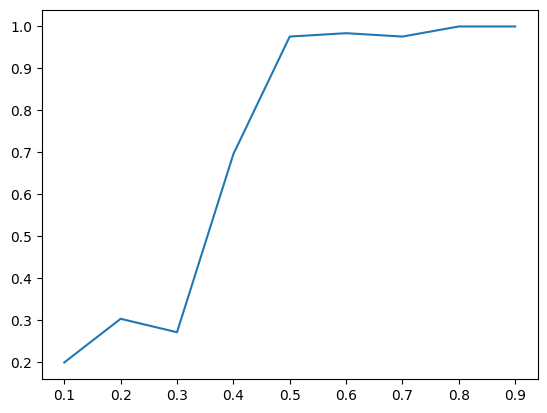

In [ ]:
L = 5
spin_list = []

for b in np.arange(0.1,1.0,0.1) :
    temp_spin = []
    for _ in range(10) :
        temp_spin.append(simul(L,b))
    spin_list.append(np.mean(temp_spin))

plt.plot(np.arange(0.1,1.0,0.1),spin_list)
plt.show()

#Sweden

In [ ]:
def P(beta):
    return 1 - np.exp(-2 * beta)

def neighbors(i, j, L):
    return [(i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j)]

def find(i, ptr):
    if ptr[i] < 0:
        return i
    else:
        ptr[i] = find(ptr[i], ptr)
        return ptr[i]

def union(r1, r2, big, ptr):
    if r2 != r1:
        if ptr[r1] > ptr[r2]:
            ptr[r2] += ptr[r1]
            ptr[r1] = r2
            r1 = r2
        else:
            ptr[r1] += ptr[r2]
            ptr[r2] = r1
        if -ptr[r1] > big:
            big = -ptr[r1]
    return r1, r2, big

def create_bonds(L):
    bonds = []
    for i in range(L):
        for j in range(L):
            c = i * L + j
            r = i * L + (j + 1) % L
            d = ((i + 1) % L) * L + j
            bonds.append((c, r))
            bonds.append((c, d))
    return bonds

def cluster_flip(initial_spin, L, beta):
    N = L * L
    ptr = np.ones(N, dtype=int) * -1
    bonds = create_bonds(L)
    big = 0

    for bond in bonds:
        choice_spin_index, neighbor_spin_index = bond
        if initial_spin[choice_spin_index] == initial_spin[neighbor_spin_index]:
            if P(beta) > random.random():
                r1 = find(choice_spin_index, ptr)
                r2 = find(neighbor_spin_index, ptr)
                r1, r2, big = union(r1, r2, big, ptr)

    clusters = set()
    for i in range(N):
        r1 = find(i, ptr)
        clusters.add(r1)

    for cluster in clusters:
        if random.random() < 0.5:
            for i in range(N):
                if find(i, ptr) == cluster:
                    initial_spin[i] *= -1

    return initial_spin

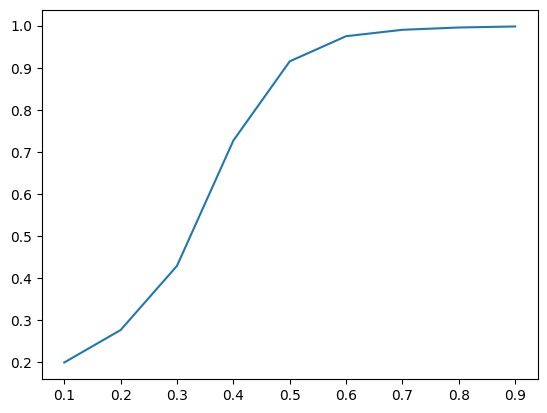

In [ ]:
L = 5
beta_list = np.arange(0.1, 1, 0.1)
M_mean_list = []

for beta in beta_list:
    m_list = []
    initial_spin = np.random.choice([-1, 1], size=(L * L))
    for _ in range(10) :
        temp_m = []
        for j in range(1000):
            initial_spin = cluster_flip(initial_spin, L, beta)
            m = np.mean(initial_spin)
            temp_m.append(abs(m))
        m_list.append(np.mean(temp_m))
    M_mean_list.append(np.mean(m_list))

plt.plot(beta_list, M_mean_list)
plt.show()

#Plot

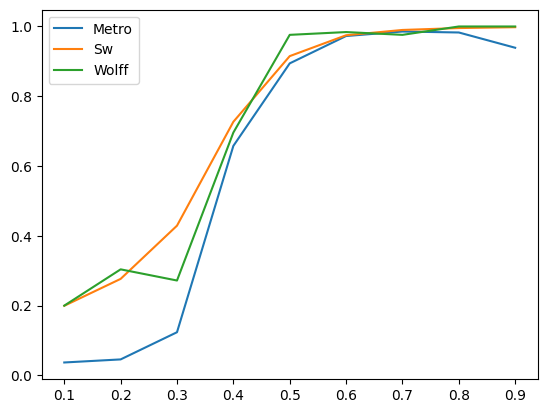

In [ ]:
plt.plot(np.arange(0.1, 1.0, 0.1),Ms,label='Metro')
plt.plot(beta_list, M_mean_list,label='Sw')
plt.plot(np.arange(0.1,1.0,0.1),spin_list,label='Wolff')
plt.legend()
plt.show()